In [285]:
from MinModule import *

import os
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics.classification import F1Score, MulticlassF1Score
import torchmetrics

from konlpy.tag import Okt

from gensim.models import Word2Vec
from collections import Counter

from sklearn.model_selection import train_test_split

In [239]:
DATA_PATH = './data/'
FILE_PATH = DATA_PATH + 'data.csv'

In [240]:
data_df = pd.read_csv(FILE_PATH)
data_df

,제목,유형,구분,장르,상영 시간,등급,국적,감독,시놉시스
0,괴도 퀸은 서커스를 좋아해,장편,일반영화,애니메이션,58분 55초,12세이상관람가,일본,NaN,괴도에게도 미학이 있다!진부한 도둑질을 거부하는 범죄 세계 유명 인사 '괴도 퀸'....
1,혼자 물 빼는 이모 거들어줬다,장편,일반영화,"성인물(에로), 드라마, 멜로/로맨스",60분 0초,청소년관람불가,일본,NaN,이모와 조카의 정사를 다룬 성애영화
2,위키드,장편,일반영화,"판타지, 뮤지컬",160분 29초,전체관람가,미국,존 추,"일자별 스크린수, 상영횟수, 관객수, 매출액 등의 통계정보입니다. 엑셀을 통해서 세..."
3,마리우폴에서의 20일,장편,예술영화,"다큐멘터리, 전쟁",94분 13초,15세이상관람가,미국,므스티슬라우 체르노우,제96회 미국 아카데미 시상식 장편 다큐멘터리상 수상!영화제 33관왕 & 퓰리처상 ...
4,괴도 퀸은 서커스를 좋아해,장편,일반영화,애니메이션,58분 55초,12세이상관람가,일본,NaN,괴도에게도 미학이 있다!진부한 도둑질을 거부하는 범죄 세계 유명 인사 '괴도 퀸'....
...,...,...,...,...,...,...,...,...,...
16129,괴수대전쟁,장편,일반영화,애니메이션,69분 0초,전체관람가,한국,용유수,21세기 어느 무렵 핵보유국들은 새로 발견한 행성 ‘그라디오라스’의 엄청난 지하자원...
16130,어둠의 표적,장편,일반영화,"드라마, 범죄, 스릴러",118분 0초,12세이상관람가,"영국, 미국",샘 페킨파,조용한 성격의 수학자 데이비드(David Sumner: 더스틴 호프만 분)는 관능적...
16131,작별,장편,예술영화,드라마,87분 0초,18세관람가,"아르헨티나, 스페인",에두르도 미노냐,언니가 남기고 간 편지 이 세상에 보내는 사랑의 작별 인사 한 순간에 교통사고로 부...
16132,화월춘야,장편,일반영화,뮤지컬,122분 0초,NaN,홍콩,이노우에 우메츠구,"일자별 스크린수, 상영횟수, 관객수, 매출액 등의 통계정보입니다. 엑셀을 통해서 세..."


In [241]:
data_df['시놉시스'].replace("일자별 스크린수, 상영횟수, 관객수, 매출액 등의 통계정보입니다. 엑셀을 통해서 세부적인 통계를 확인할 수 있습니다.", "/", inplace = True)
data_df.replace(np.NAN, '/', inplace = True)
data_df

,제목,유형,구분,장르,상영 시간,등급,국적,감독,시놉시스
0,괴도 퀸은 서커스를 좋아해,장편,일반영화,애니메이션,58분 55초,12세이상관람가,일본,/,괴도에게도 미학이 있다!진부한 도둑질을 거부하는 범죄 세계 유명 인사 '괴도 퀸'....
1,혼자 물 빼는 이모 거들어줬다,장편,일반영화,"성인물(에로), 드라마, 멜로/로맨스",60분 0초,청소년관람불가,일본,/,이모와 조카의 정사를 다룬 성애영화
2,위키드,장편,일반영화,"판타지, 뮤지컬",160분 29초,전체관람가,미국,존 추,/
3,마리우폴에서의 20일,장편,예술영화,"다큐멘터리, 전쟁",94분 13초,15세이상관람가,미국,므스티슬라우 체르노우,제96회 미국 아카데미 시상식 장편 다큐멘터리상 수상!영화제 33관왕 & 퓰리처상 ...
4,괴도 퀸은 서커스를 좋아해,장편,일반영화,애니메이션,58분 55초,12세이상관람가,일본,/,괴도에게도 미학이 있다!진부한 도둑질을 거부하는 범죄 세계 유명 인사 '괴도 퀸'....
...,...,...,...,...,...,...,...,...,...
16129,괴수대전쟁,장편,일반영화,애니메이션,69분 0초,전체관람가,한국,용유수,21세기 어느 무렵 핵보유국들은 새로 발견한 행성 ‘그라디오라스’의 엄청난 지하자원...
16130,어둠의 표적,장편,일반영화,"드라마, 범죄, 스릴러",118분 0초,12세이상관람가,"영국, 미국",샘 페킨파,조용한 성격의 수학자 데이비드(David Sumner: 더스틴 호프만 분)는 관능적...
16131,작별,장편,예술영화,드라마,87분 0초,18세관람가,"아르헨티나, 스페인",에두르도 미노냐,언니가 남기고 간 편지 이 세상에 보내는 사랑의 작별 인사 한 순간에 교통사고로 부...
16132,화월춘야,장편,일반영화,뮤지컬,122분 0초,/,홍콩,이노우에 우메츠구,/


In [242]:
data_df['text'] = data_df['시놉시스'] + ' ' + data_df['등급'] + ' ' + data_df['국적'] + ' ' + data_df['감독']

In [243]:
data_df

,제목,유형,구분,장르,상영 시간,등급,국적,감독,시놉시스,text
0,괴도 퀸은 서커스를 좋아해,장편,일반영화,애니메이션,58분 55초,12세이상관람가,일본,/,괴도에게도 미학이 있다!진부한 도둑질을 거부하는 범죄 세계 유명 인사 '괴도 퀸'....,괴도에게도 미학이 있다!진부한 도둑질을 거부하는 범죄 세계 유명 인사 '괴도 퀸'....
1,혼자 물 빼는 이모 거들어줬다,장편,일반영화,"성인물(에로), 드라마, 멜로/로맨스",60분 0초,청소년관람불가,일본,/,이모와 조카의 정사를 다룬 성애영화,이모와 조카의 정사를 다룬 성애영화 청소년관람불가 일본 /
2,위키드,장편,일반영화,"판타지, 뮤지컬",160분 29초,전체관람가,미국,존 추,/,/ 전체관람가 미국 존 추
3,마리우폴에서의 20일,장편,예술영화,"다큐멘터리, 전쟁",94분 13초,15세이상관람가,미국,므스티슬라우 체르노우,제96회 미국 아카데미 시상식 장편 다큐멘터리상 수상!영화제 33관왕 & 퓰리처상 ...,제96회 미국 아카데미 시상식 장편 다큐멘터리상 수상!영화제 33관왕 & 퓰리처상 ...
4,괴도 퀸은 서커스를 좋아해,장편,일반영화,애니메이션,58분 55초,12세이상관람가,일본,/,괴도에게도 미학이 있다!진부한 도둑질을 거부하는 범죄 세계 유명 인사 '괴도 퀸'....,괴도에게도 미학이 있다!진부한 도둑질을 거부하는 범죄 세계 유명 인사 '괴도 퀸'....
...,...,...,...,...,...,...,...,...,...,...
16129,괴수대전쟁,장편,일반영화,애니메이션,69분 0초,전체관람가,한국,용유수,21세기 어느 무렵 핵보유국들은 새로 발견한 행성 ‘그라디오라스’의 엄청난 지하자원...,21세기 어느 무렵 핵보유국들은 새로 발견한 행성 ‘그라디오라스’의 엄청난 지하자원...
16130,어둠의 표적,장편,일반영화,"드라마, 범죄, 스릴러",118분 0초,12세이상관람가,"영국, 미국",샘 페킨파,조용한 성격의 수학자 데이비드(David Sumner: 더스틴 호프만 분)는 관능적...,조용한 성격의 수학자 데이비드(David Sumner: 더스틴 호프만 분)는 관능적...
16131,작별,장편,예술영화,드라마,87분 0초,18세관람가,"아르헨티나, 스페인",에두르도 미노냐,언니가 남기고 간 편지 이 세상에 보내는 사랑의 작별 인사 한 순간에 교통사고로 부...,언니가 남기고 간 편지 이 세상에 보내는 사랑의 작별 인사 한 순간에 교통사고로 부...
16132,화월춘야,장편,일반영화,뮤지컬,122분 0초,/,홍콩,이노우에 우메츠구,/,/ / 홍콩 이노우에 우메츠구


In [244]:
data_df.columns

Index(['제목', '유형', '구분', '장르', '상영 시간', '등급', '국적', '감독', '시놉시스', 'text'], dtype='object')

In [245]:
data_df.drop(['유형', '구분', '상영 시간', '등급', '국적', '감독', '시놉시스'], axis = 1, inplace = True)

In [246]:
data_df

,제목,장르,text
0,괴도 퀸은 서커스를 좋아해,애니메이션,괴도에게도 미학이 있다!진부한 도둑질을 거부하는 범죄 세계 유명 인사 '괴도 퀸'....
1,혼자 물 빼는 이모 거들어줬다,"성인물(에로), 드라마, 멜로/로맨스",이모와 조카의 정사를 다룬 성애영화 청소년관람불가 일본 /
2,위키드,"판타지, 뮤지컬",/ 전체관람가 미국 존 추
3,마리우폴에서의 20일,"다큐멘터리, 전쟁",제96회 미국 아카데미 시상식 장편 다큐멘터리상 수상!영화제 33관왕 & 퓰리처상 ...
4,괴도 퀸은 서커스를 좋아해,애니메이션,괴도에게도 미학이 있다!진부한 도둑질을 거부하는 범죄 세계 유명 인사 '괴도 퀸'....
...,...,...,...
16129,괴수대전쟁,애니메이션,21세기 어느 무렵 핵보유국들은 새로 발견한 행성 ‘그라디오라스’의 엄청난 지하자원...
16130,어둠의 표적,"드라마, 범죄, 스릴러",조용한 성격의 수학자 데이비드(David Sumner: 더스틴 호프만 분)는 관능적...
16131,작별,드라마,언니가 남기고 간 편지 이 세상에 보내는 사랑의 작별 인사 한 순간에 교통사고로 부...
16132,화월춘야,뮤지컬,/ / 홍콩 이노우에 우메츠구


In [247]:
L = []

for genre in data_df['장르']:
    L.append(genre.split(',')[0])

data_df['장르'] = L

In [248]:
L = []

for genre in data_df['장르']:
    if genre in ['드라마', '멜로/로맨스', '액션', '코미디', '애니메이션',
                     '다큐멘터리', '공연', '가족', '판타지', '뮤지컬']:
        L.append('나머지')
    
    else:
        L.append(genre)

In [249]:
data_df['장르'] = L

data_df['장르'].value_counts()

장르
나머지         10273
성인물(에로)      3573
공포(호러)        598
스릴러           470
SF            337
범죄            302
미스터리          150
사극            122
어드벤처           96
기타             94
전쟁             92
서부극(웨스턴)       27
Name: count, dtype: int64

In [253]:

def remove_punctuation_korean(text):
    if isinstance(text, str):
        return re.sub(r'[^가-힣0-9\s]', '', text)  
    return text


data_df = data_df.applymap(remove_punctuation_korean)

stopwords = 'stop_words.txt'
def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()  # 공백을 기준으로 텍스트를 단어로 나눔
        filtered_words = [word for word in words if word not in stopwords]  # 불용어 제외
        return ' '.join(filtered_words)  # 불용어를 제외한 단어들을 다시 합침
    return text

# 데이터프레임의 모든 열에 대해 불용어 제거 적용
data_df = data_df.applymap(remove_stopwords)

In [260]:
# train/test 데이터셋 분리

trainDF = data_df.sample(frac=0.9, random_state=42) 
testDF = data_df.drop(trainDF.index)                 

trainDF

,제목,장르,text
7900,정복자 윌리엄,전쟁,영원한 군주를 꿈꾸던 윌리엄 새 시대를 열다어느 날 갑자기 로베르 1세가 암살을 당...
2254,모딜리아니,나머지,1919년 파리 뜨겁고 파괴적이었던 세기의 예술가 모딜리아니는 술과 마약에 중독되어...
13539,익스트랙티드,나머지,누군가의 기억이 당신을 가두는 감옥이 된다천재 과학자 톰사샤 로이즈은 사람의 기억을...
7171,피부를 판 남자,나머지,이 작품은 살아있습니다 불편을 끼쳐 죄송합니다 자유 돈 명예를 드립니다 당신의 피부...
6051,임신하고 싶다는 며느리,성인물에로,곧 결혼식을 올리기로 하고 혼인신고 전 미리 동거하고 있는 민지와 수형수형은 백수로...
...,...,...,...
2079,쇼킹 마사지 샵,나머지,청소년관람불가 일본
11581,전격자,나머지,국제범죄단의 마군호는 은사의 아들 사메가 마약밀매조직의 하수인으로 이용당하는 것을 ...
8914,세 여자의 유혹,성인물에로,룸메이트큰 집에서 함께 지내던 룸메이트가 집을 나가게 되자 남자는 집을 함께 쓸 룸...
951,우묵배미의 사랑,나머지,배일도는 시골에서 구박덩이로 크다가 일찌기 집을 나와 갖은 고생을 하며 지금은 미싱...


In [261]:
testDF

,제목,장르,text
4,괴도 퀸은 서커스를 좋아해,나머지,괴도에게도 미학이 있다진부한 도둑질을 거부하는 범죄 세계 유명 인사 괴도 퀸퀸의 이...
5,혼자 물 빼는 이모 거들어줬다,성인물에로,이모와 조카의 정사를 다룬 성애영화 청소년관람불가 일본
9,그 집 마담 허리 잘 돌리더라,성인물에로,작은 팝을 운영하는 마담이 손님들에게 제공하는 특별한 서비스에 관한 이야기를 다룬 ...
55,극장판 오버로드 성왕국,나머지,성왕녀 칼카가 통치하는 로블 성왕국은길고 거대한 성벽을 쌓고 그 안에서 평화로운 시...
64,줄리엣 네이키드,나머지,25년 전 앨범을 내고 홀연히 사라진 싱어송라이터 터커 크로우에단 호크애니로즈 번는...
...,...,...,...
16101,막달레나 시스터즈,나머지,누구에 대한 죄인가 누구를 위한 용서인가 1964년 아일랜드의 시골마을 네 명의 여...
16102,보이지 않는 물결,나머지,지울 수 없는 기억과 함께 시작된 그 남자의 여행마카오의 한 식당에서 부 주방장으로...
16107,용서,나머지,이슬람교를 정식종교로 채택 태어날 때부터 부모의 종교를 반드시 따라야만 하는 이스라...
16112,아기 거북 토토의 바다 대모험,나머지,아기 거북이의 용감한 바다 여행이 시작된다미국 플로리다 해변가에서 태어난 아기 바다...


In [254]:
data_df

,제목,장르,text
0,괴도 퀸은 서커스를 좋아해,나머지,괴도에게도 미학이 있다진부한 도둑질을 거부하는 범죄 세계 유명 인사 괴도 퀸퀸의 이...
1,혼자 물 빼는 이모 거들어줬다,성인물에로,이모와 조카의 정사를 다룬 성애영화 청소년관람불가 일본
2,위키드,나머지,전체관람가 미국 존 추
3,마리우폴에서의 20일,나머지,제96회 미국 아카데미 시상식 장편 다큐멘터리상 수상영화제 33관왕 퓰리처상 수상에...
4,괴도 퀸은 서커스를 좋아해,나머지,괴도에게도 미학이 있다진부한 도둑질을 거부하는 범죄 세계 유명 인사 괴도 퀸퀸의 이...
...,...,...,...
16129,괴수대전쟁,나머지,21세기 어느 무렵 핵보유국들은 새로 발견한 행성 그라디오라스의 엄청난 지하자원을 ...
16130,어둠의 표적,나머지,조용한 성격의 수학자 데이비드 더스틴 호프만 분는 관능적인 여인 에이미 수잔 죠지 ...
16131,작별,나머지,언니가 남기고 간 편지 이 세상에 보내는 사랑의 작별 인사 한 순간에 교통사고로 부...
16132,화월춘야,나머지,홍콩 이노우에 우메츠구


In [279]:
data_df['장르'].value_counts()

장르
나머지       10273
성인물에로      3573
공포호러        598
스릴러         470
            337
범죄          302
미스터리        150
사극          122
어드벤처         96
기타           94
전쟁           92
서부극웨스턴       27
Name: count, dtype: int64

In [264]:
def build_vocab(corpus, n_vocab, special_tokens): 
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab): 
        vocab.append(token)
    return vocab

In [262]:
## 불용어 리스트 함수
STOP_PATH = 'stop_words.txt'

def make_stopwords(STOP_PATH):
    with open(STOP_PATH, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines() 
    return set(stopwords)        

In [263]:
stopwords = make_stopwords(STOP_PATH)

In [265]:
tokenizer = Okt()
train_tokens = [[token for token in tokenizer.morphs(review) if (token not in stopwords) ] for review in trainDF.text]   # 형태소 단위로 나눠서 리스트에 저장
test_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords] for review in testDF.text]

vocab = build_vocab(corpus=train_tokens, n_vocab=50000, special_tokens=["<pad>", "<unk>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for idx, token in enumerate(vocab)}

print(vocab[:10])
print(len(vocab))


['<pad>', '<unk>', '관람', '한다', '하는', '된다', '불가', '청소년', '한국', '사랑']
50002


In [266]:
vocab_file = 'vocab.pkl'

with open(vocab_file, 'wb') as f:
    pickle.dump(vocab, f)

In [267]:
def build_vocab(corpus, n_vocab, special_tokens): 
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab): 
        vocab.append(token)
    return vocab

In [268]:
def check_data(data):
    i = 0
    for _ in data:
        print(_)
        i += 1
        if i == 10:
            break

In [269]:
def pad_sequences(sequences, max_length, pad_value) :
    result = list()
    for sequence in sequences :
        sequence = sequence[:max_length]
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length
        result.append(padded_sequence)
    return np.array(result)

unk_id = token_to_id['<unk>']                                  ## token_to_id 에서 <unk>에 해당하는 인덱스 번호를 unk_id에 저장

## train_tokens에서 review를 가져오고 가져온 review를 token으로 나눔
## 나누어진 token을 token_to_id에 있는지 비교하고 있다면 인덱스를 반환 없다면 unk_id를 반환
train_ids =[
    [token_to_id.get(token,unk_id) for token in review] for review in train_tokens
]
test_ids =[
    [token_to_id.get(token,unk_id) for token in review] for review in test_tokens
]

max_length = 50
pad_id = token_to_id['<pad>']
train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)


In [292]:
with open('min_vocab.pkl', 'wb') as f:
    pickle.dump(token_to_id, f)

In [270]:
check_data(train_ids)
print()
check_data(test_ids)

[ 1989  5897  2371  1702   527 25497   149  5376   168   747   707  5709
   849 13167 13168  3004   189  1678  2577  5376   168  2372  1702  2900
   227   772  4463  1379  9152  1915 10179  3320 19142    20     2    91
 19143 14285     0     0     0     0     0     0     0     0     0     0
     0     0]
[30947   441 14286   708   403   703  2484 19144   124   184  1350    38
 25498   148  1078 25499 19145    19  9153  1871  5547   564  1605 11464
 41191 19144   170   870  2249    38   119     9   349   870 19144  2163
   945  5710   362   650 21813  4464  3380   870  3381 19146    47 19147
 13169   616]
[  390   122 30950   409     5   554  1502   783  6573  1656   122 41192
  1805  4701  1679  8743  7964  5090     5  7964  3688  8743  4702  8356
   681  9604    83  1394  1206   724   184  1350 12228  3519   364 11465
    33    16  9605  7316  5898   545     9     4    28    62   681  7637
    14     5]
[  362 41195 25500 41196 30951   696    48  1639 14288  4825 41197   696
    48  1

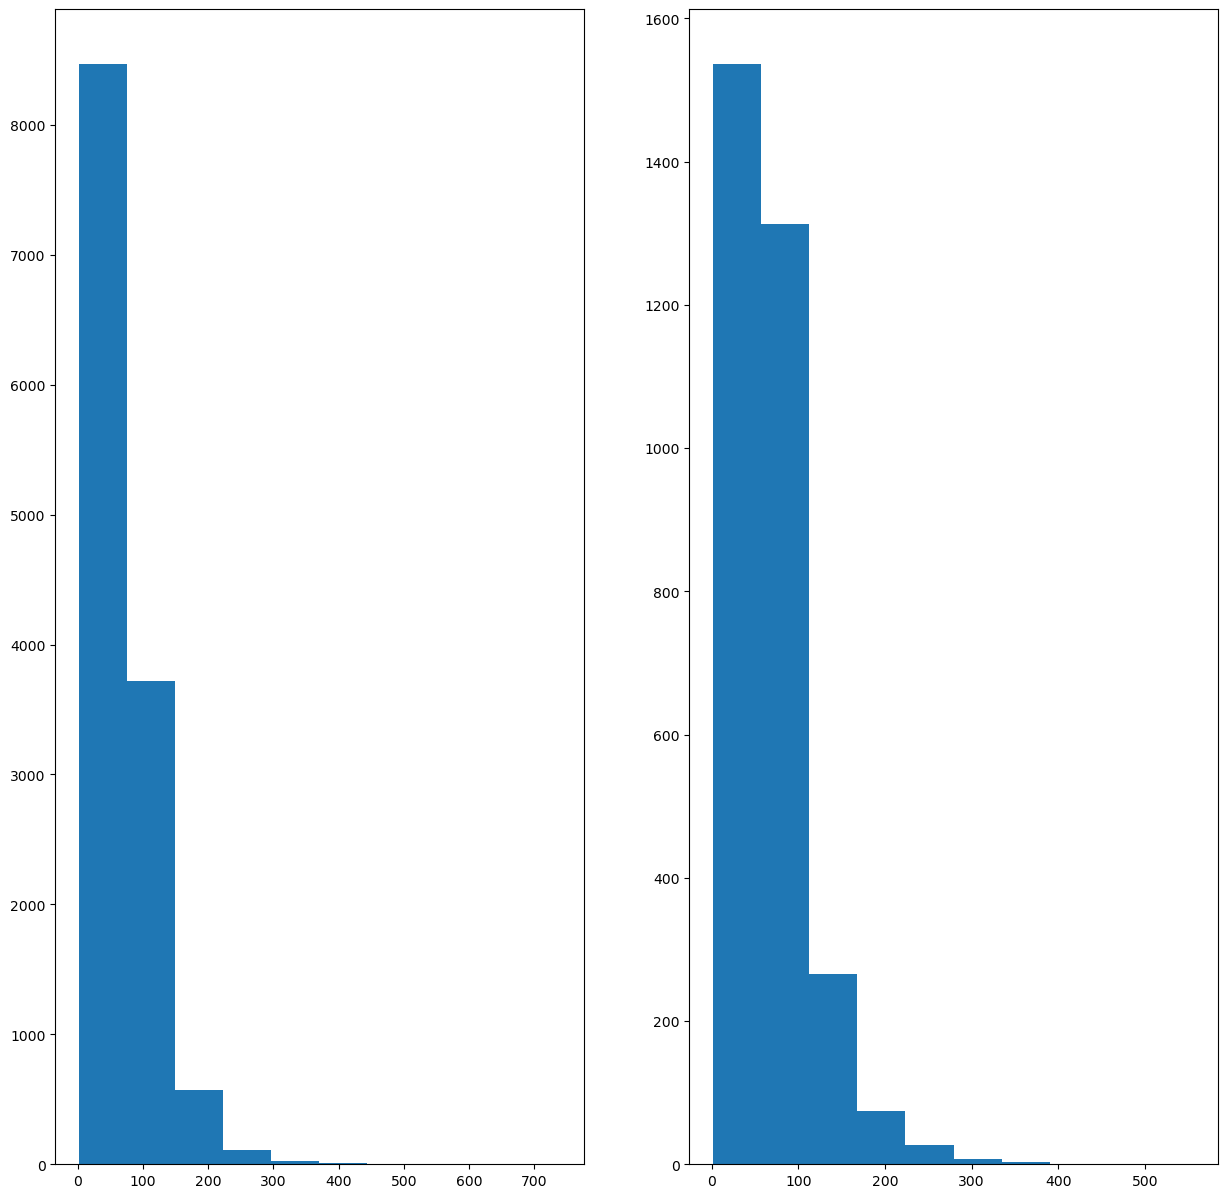

In [87]:
train_data_length = [len(data) for data in train_ids]
test_data_length = [len(data) for data in test_ids]

fig = plt.figure(figsize = (15, 15))
axes = fig.subplots(1, 2)
axes[0].hist(train_data_length)
axes[1].hist(test_data_length)

plt.show()

In [293]:
trainDF['text']

7900     영원한 군주를 꿈꾸던 윌리엄 새 시대를 열다어느 날 갑자기 로베르 1세가 암살을 당...
2254     1919년 파리 뜨겁고 파괴적이었던 세기의 예술가 모딜리아니는 술과 마약에 중독되어...
13539    누군가의 기억이 당신을 가두는 감옥이 된다천재 과학자 톰사샤 로이즈은 사람의 기억을...
7171     이 작품은 살아있습니다 불편을 끼쳐 죄송합니다 자유 돈 명예를 드립니다 당신의 피부...
6051     곧 결혼식을 올리기로 하고 혼인신고 전 미리 동거하고 있는 민지와 수형수형은 백수로...
                               ...                        
2079                                            청소년관람불가 일본
11581    국제범죄단의 마군호는 은사의 아들 사메가 마약밀매조직의 하수인으로 이용당하는 것을 ...
8914     룸메이트큰 집에서 함께 지내던 룸메이트가 집을 나가게 되자 남자는 집을 함께 쓸 룸...
951      배일도는 시골에서 구박덩이로 크다가 일찌기 집을 나와 갖은 고생을 하며 지금은 미싱...
8058     성인 배우가 되고 싶은 신인 배우와 감독과의 관계를 다룬 성애영화 청소년관람불가 한...
Name: text, Length: 14521, dtype: object

In [275]:
label = dict(zip(trainDF['장르'].value_counts().index, range(12)))
label

{'나머지': 0,
 '성인물에로': 1,
 '공포호러': 2,
 '스릴러': 3,
 '': 4,
 '범죄': 5,
 '미스터리': 6,
 '사극': 7,
 '어드벤처': 8,
 '기타': 9,
 '전쟁': 10,
 '서부극웨스턴': 11}

In [276]:
L = []

for i in trainDF['장르']:
    L.append(label[i])
        
trainDF['장르'] = L

trainDF

,제목,장르,text
7900,정복자 윌리엄,10,영원한 군주를 꿈꾸던 윌리엄 새 시대를 열다어느 날 갑자기 로베르 1세가 암살을 당...
2254,모딜리아니,0,1919년 파리 뜨겁고 파괴적이었던 세기의 예술가 모딜리아니는 술과 마약에 중독되어...
13539,익스트랙티드,0,누군가의 기억이 당신을 가두는 감옥이 된다천재 과학자 톰사샤 로이즈은 사람의 기억을...
7171,피부를 판 남자,0,이 작품은 살아있습니다 불편을 끼쳐 죄송합니다 자유 돈 명예를 드립니다 당신의 피부...
6051,임신하고 싶다는 며느리,1,곧 결혼식을 올리기로 하고 혼인신고 전 미리 동거하고 있는 민지와 수형수형은 백수로...
...,...,...,...
2079,쇼킹 마사지 샵,0,청소년관람불가 일본
11581,전격자,0,국제범죄단의 마군호는 은사의 아들 사메가 마약밀매조직의 하수인으로 이용당하는 것을 ...
8914,세 여자의 유혹,1,룸메이트큰 집에서 함께 지내던 룸메이트가 집을 나가게 되자 남자는 집을 함께 쓸 룸...
951,우묵배미의 사랑,0,배일도는 시골에서 구박덩이로 크다가 일찌기 집을 나와 갖은 고생을 하며 지금은 미싱...


In [277]:
L = []

for i in testDF['장르']:
    L.append(label[i])
        
testDF['장르'] = L

testDF

,제목,장르,text
4,괴도 퀸은 서커스를 좋아해,0,괴도에게도 미학이 있다진부한 도둑질을 거부하는 범죄 세계 유명 인사 괴도 퀸퀸의 이...
5,혼자 물 빼는 이모 거들어줬다,1,이모와 조카의 정사를 다룬 성애영화 청소년관람불가 일본
9,그 집 마담 허리 잘 돌리더라,1,작은 팝을 운영하는 마담이 손님들에게 제공하는 특별한 서비스에 관한 이야기를 다룬 ...
55,극장판 오버로드 성왕국,0,성왕녀 칼카가 통치하는 로블 성왕국은길고 거대한 성벽을 쌓고 그 안에서 평화로운 시...
64,줄리엣 네이키드,0,25년 전 앨범을 내고 홀연히 사라진 싱어송라이터 터커 크로우에단 호크애니로즈 번는...
...,...,...,...
16101,막달레나 시스터즈,0,누구에 대한 죄인가 누구를 위한 용서인가 1964년 아일랜드의 시골마을 네 명의 여...
16102,보이지 않는 물결,0,지울 수 없는 기억과 함께 시작된 그 남자의 여행마카오의 한 식당에서 부 주방장으로...
16107,용서,0,이슬람교를 정식종교로 채택 태어날 때부터 부모의 종교를 반드시 따라야만 하는 이스라...
16112,아기 거북 토토의 바다 대모험,0,아기 거북이의 용감한 바다 여행이 시작된다미국 플로리다 해변가에서 태어난 아기 바다...


In [280]:
# 정수 인코딩 된 단어 tensor화
train_ids = torch.tensor(train_ids)             ## TensorDataset 클래스에 적용을 위해 tensor 형태로 변환
test_ids = torch.tensor(test_ids)               ## TensorDataset 클래스에 적용을 위해 tensor 형태로 변환

train_labels = torch.tensor(trainDF.장르.values, dtype=torch.float32)
test_labels = torch.tensor(testDF.장르.values, dtype=torch.float32)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

C:\Users\KDP-2\AppData\Local\Temp\ipykernel_29712\1964838697.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_ids = torch.tensor(train_ids)             ## TensorDataset 클래스에 적용을 위해 tensor 형태로 변환
C:\Users\KDP-2\AppData\Local\Temp\ipykernel_29712\1964838697.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_ids = torch.tensor(test_ids)               ## TensorDataset 클래스에 적용을 위해 tensor 형태로 변환


In [283]:
train_labels

tensor([10.,  0.,  0.,  ...,  1.,  0.,  1.])

In [284]:
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)

with open('train_loader.pkl', 'wb') as f:
    pickle.dump(train_loader, f)

with open('test_loader.pkl', 'wb') as f:
    pickle.dump(test_loader, f)

with open('token_to_id.pkl', 'wb') as f:
    pickle.dump(token_to_id, f)


In [190]:
label = dict(zip(train_labels.value_counts().index, range(12)))
label

{'나머지': 0,
 '성인물(에로)': 1,
 '공포(호러)': 2,
 '스릴러': 3,
 'SF': 4,
 '범죄': 5,
 '미스터리': 6,
 '사극': 7,
 '어드벤처': 8,
 '기타': 9,
 '전쟁': 10,
 '서부극(웨스턴)': 11}

In [288]:
# word2vec의 vector_size와 embedding_dim의 크기가 같아야 되는거 같다.

n_vocab = len(token_to_id)
hidden_dim = 64
embedding_dim = 128
n_layers = 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [289]:
n_vocab

50002

In [229]:
# 문장 분류 모델 

class SentenceClassifier(nn.Module):
    def __init__(self,
                 n_vocab = n_vocab,
                 hidden_dim = hidden_dim,
                 embedding_dim = embedding_dim,
                 n_layers = n_layers,
                 dropout = 0.5,
                 # 양방향은 빈칸에 들어갈 단어를 고르는 등, 앞 문장과 뒷 문장이 둘 다 중요할 때 사용
                 bidirectional = True,
                 model_type = 'lstm',
                 pretrained_embedding = None,
                 n_classes = 12
                 ):
        super().__init__()

        if pretrained_embedding is not None:
            self.embedding = nn.Embedding.from_pretrained(
                torch.tensor(pretrained_embedding, dtype = torch.float32)
            )
        else:
            self.embedding = nn.Embedding(
                num_embeddings = n_vocab,
                embedding_dim = embedding_dim,
                padding_idx = 0
        )
        
        if model_type == 'rnn':
            self.model = nn.RNN(
                input_size = embedding_dim,
                hidden_size = hidden_dim,
                num_layers = n_layers,
                bidirectional = bidirectional,
                dropout = dropout,
                batch_first = True
            )
        elif model_type == 'lstm':
            self.model = nn.LSTM(
                input_size = embedding_dim,
                hidden_size = hidden_dim,
                num_layers = n_layers,
                bidirectional = bidirectional,
                dropout = dropout,
                batch_first = True
            )
        
        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, n_classes)

        else:
            self.classifier = nn.Linear(hidden_dim, n_classes)

        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [230]:
classifier = SentenceClassifier().to(DEVICE)

In [286]:
EPOCH = 1000
LR = 0.001

device = 'cuda' if torch.cuda.is_available() else 'cpu'

optimizer = optim.Adam(classifier.parameters(), lr = LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device)

In [287]:
# 저장 경로 설정
SAVE_PATH = './model/movie/'
SAVE_FILE = os.path.join(SAVE_PATH, 'model_movie_train_wbs.pth')
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [ ]:
def train(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes = 12).to(device)  

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        yhat = (torch.softmax(logits)).float()  
        accuracy_metric.update(yhat, labels) 

        if step % interval == 0:
            print(f'Train Loss {step} : {np.mean(losses)}')

    train_accuracy = accuracy_metric.compute()
    return np.mean(losses), train_accuracy 


def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes = 12).to(device)

    all_predictions = [] # 예측값 저장
    all_labels = []  # 실제값 저장장

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        yhat = torch.sigmoid(logits) > 0.5
        accuracy_metric.update(yhat, labels)

        all_predictions.extend(yhat.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy())  

    accuracy = accuracy_metric.compute()

    print(f'Val Loss: {np.mean(losses)}, Val Accuracy: {accuracy:.4f}')
    print(f'Predictions: {all_predictions[-10:]}') 
    print(f'Actuals: {all_labels[-10:]}')  
    return np.mean(losses), accuracy 


# 학습 및 평가 루프
epochs = 50
interval = 500
best_accuracy = 0.0  
SAVE_FILE = 'best_model.pth'

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    train_loss, train_accuracy = train(classifier, train_loader, criterion, optimizer, device, interval)
    val_loss, current_accuracy = test(classifier, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(current_accuracy.item())

    scheduler.step()

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')  

    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,  
        }, SAVE_FILE)
        print(f"best model accuracy : {best_accuracy:.4f} epoch : {epoch}")
    else:
        print(f"향상 없음: {best_accuracy:.4f}")

print(f'학습 완료 - best model accuracy : {best_accuracy:.4f}')




